<a href="https://colab.research.google.com/github/acollin19/comp551/blob/Angele/A2/assignment2_group_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

## Process:

### Task 1: Data Processing  


1. IMDB Reviews
2. 20 news groups: a multi-class labelled textual dataset


### Task 2: Implement Logistic and Multiclass classifiers

1. Logistic Regression
2. Multiclass Regression
3. Comparisons using ROC curve


### Task 3: Running Experiments



1.    Most positive/negative Z-scores
2.   Implement:  
    * Binary classification on the IMDB Reviews

  *   Multi-class classification on the 20 news group dataset

3. Binary classification AUROC on IMDB data
  *   Logistic Regression 
  *   KNN

4. Multiclass classification accuracy

5. Compare Accuracy of Models (Plot)







In [29]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix
import scipy.sparse as sp


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Multiclass Regression and ROC curve comparisons
from sklearn import model_selection
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from nltk import word_tokenize, download
from nltk.corpus import stopwords


In [105]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!ls aclImdb
!ls aclImdb/test
!ls aclImdb/train


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  44.6M      0  0:00:01  0:00:01 --:--:-- 44.6M
imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


In [106]:
# IMDB dataset preprocession
IMDB_X_train, IMDB_y_train= load_svmlight_file('aclImdb/train/labeledBow.feat')
IMDB_X_test, IMDB_y_test = load_svmlight_file('aclImdb/test/labeledBow.feat') 

# Binary Classification : change ratings to 1/0 if above/below 5

IMDB_y_train[IMDB_y_train < 5] = 1
IMDB_y_train[IMDB_y_train >= 5] = 0
IMDB_y_test[IMDB_y_test < 5] = 1
IMDB_y_test[IMDB_y_test >= 5] = 0

# Task 1 : Data processing



\## Task 1.1 : IMDB

 - X contain features based on the words in the movie reviews
 - y contain labels for whether the review score

In [107]:
# 1st element in tuple represents the file its in, 2nd element represents the index of word it represents in vocab, float represents frequency
# want to remove the words that appear in less than 1% of all documents # only appear in 250 documents
# want to remove the words that appear in more than 50% of all documents # appear in 12500 documents

sign = IMDB_X_train.sign()
num_file_occurences_train = np.asarray(sign.sum(axis=0))# number of files each word appears in
indices = np.intersect1d((np.flatnonzero(12500 > num_file_occurences_train)), (np.flatnonzero(250 < num_file_occurences_train)))


# Trim dataset to indices
IMDB_X_train = IMDB_X_train[:,indices]
IMDB_X_test = IMDB_X_test[:,indices]


## Z-Score Function

In [108]:
from sklearn.utils.extmath import sparse

# Map in df 
data = open('aclImdb/imdb.vocab')
vocab = data.read().split('\n')

# get correct indexed word list
word_list = [vocab[i]for i in indices]

# Z - Score
def zscore(X,y):

  N = X.shape[0]
  std = (y - y.mean()) / y.std()
  z = sp.csr_matrix.dot(sp.csr_matrix.transpose(X),std)/ np.sqrt(N)
  absZ = np.abs(z)
  return (absZ,z)

zscores, noAbsZ = zscore(IMDB_X_train,IMDB_y_train)

data = list(zip(zscores,noAbsZ,word_list))
df = pd.DataFrame.from_records(data, columns =['zscore', 'nonAbsZscore', 'word'])
df['indices'] = df.index

# get between [100,1000] range
df = df.loc[101:400:1]
zindices = df['indices'].tolist()

# reindex word list with new indices
word_list = [word_list[i] for i in zindices]

# index feature and label sets
imdb_X_train = IMDB_X_train[:,zindices].toarray()
imdb_X_test = IMDB_X_test[:,zindices].toarray()
IMDB_X_train = IMDB_X_train.toarray()
IMDB_X_test = IMDB_X_test.toarray()


In [9]:
# Loading 20 news group dataset
categories=['rec.sport.hockey','sci.electronics','talk.politics.guns','sci.space']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, remove=(['headers', 'footers', 'quotes']), shuffle=True, random_state=42)

'''
Cleaning: 
- filter out rare words, stopwords, and words that are not relevant to any of the 4 class labels.
- MI to select the top M ∈ [10, 100] feature words per class and take the union of all top feature words to train your multiclass model.

'''

download('punkt') #tokenizer, run once
download('stopwords') #stopwords dictionary, run once

# Tokenize, remove stopwords
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    # Restricts string to alphabetic characters only
    doc = [word for word in doc if word.isalpha()] 
    return doc

# text and ground truth labels
texts, y = twenty_train.data, twenty_train.target

corpus = [preprocess(text) for text in texts]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Task 1.2 : Twenty Train

Text preprocessing, tokenizing and filtering of stopwords are all included in the CountVectorizer function


In [ ]:
# Turn the text content into feature vectors
count_vect = CountVectorizer() 
X_train_counts = count_vect.fit_transform(twenty_train.data) # builds a dict of features and transforms docs to feature vectors
X_train_counts.shape

# Occurences to frequences : TF_IDF

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
X = twenty_train.data # Test content

# Turn the text content into feature vectors
count_vect = CountVectorizer() 
X_train_counts = count_vect.fit_transform(twenty_train.data) # builds a dict of features and transforms docs to feature vectors
X_train_counts.shape

# Occurences to frequences : TF_IDF

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X = X_train_tfidf
X.todense()
twenty_train_arr = X.toarray()

y_cat = twenty_train.target
# convert array of class indices to one-hot encoded array
y = np.zeros((y_cat.size, y_cat.max() + 1))
y[np.arange(y_cat.size), y_cat] = 1

#print(zscore(twenty_train_arr))

# Task 2 : Implementing Classes

## Task 2.1 : Logistic Regression Class

In [109]:
# Logistic function
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
z = np.linspace(-5,5,50)

# From class Logistic Regression collab
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh
 

### Evaluation using Logistic Regression


In [110]:
# Applying Logistic Regression on the IMDB data

model = LogisticRegression(max_iters=1e3,learning_rate=.1, epsilon=1e-4)
fit = model.fit(imdb_X_train,IMDB_y_train)


y_train_pred = fit.predict(imdb_X_train)
y_test_pred = fit.predict(imdb_X_test)

# Threshold probabilities
y_train_pred = (y_train_pred > 0.5).astype(int)
y_test_pred = (y_test_pred > 0.5).astype(int)

# Accuracy = correctly classified / total classified
acc_train = sum(y_train_pred==IMDB_y_train)/len(IMDB_y_train)
acc_test = sum(y_test_pred==IMDB_y_test)/len(IMDB_y_test)

print(f"train accuracy: {acc_train:.3f}; test accuracy: {acc_test:.3f}")


train accuracy: 0.798; test accuracy: 0.796


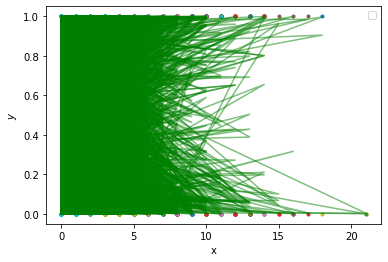

In [26]:
fit = model.fit(imdb_X_train,IMDB_y_train).predict(imdb_X_train)
plt.plot(imdb_X_train, IMDB_y_train, '.')#, label='dataset')
plt.plot(imdb_X_train, fit, 'g', alpha=.5),# label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

## Task 2.2 : Multiclass Regression Class

In [ ]:
# From class Multiclass Regression collab
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()

    def evaluate(self, y, y_pred):
      accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
      accuracy = accuracy / y.shape[0]

      return accuracy

### Evaluation using Multiclass Regression

In [ ]:
# Applying Multiclass Regression on the 4-class prediction from the 20-news-group data

# Split the data into training, validation, and testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.33, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

#Create model object
D = X.shape[1]
C = y.shape[1]

mlr = Multinomial_logistic(D, C)

# check grad
print(mlr.check_grad(X_train, y_train))



# Task 3 : Running Experiments

## Task 3.1 : Z-Scores
Report top 10 features with most positive/negative z-scores on the IMDB data using simple linear regression on the movie rating scores.  

QUESTION TO ANSWER: Do they make sense for calling a movie good and bad, respectively?


ANSWER: The top features with the most positive z-scores do make sense as it includes words like 'family', 'beutifully','excellent','wonderful' which are all generally used with a positive connotation. 
Likewise, the top features with the most negative make sense with calling a movie bad as it includes words such as 'worst', 'terrible', 'awful', 'stupid', which are all associated with negative connotation and can imply that a movie is bad.




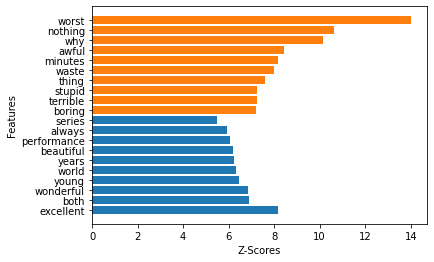

In [120]:
neg = df.sort_values('nonAbsZscore').tail(10)
pos = df.sort_values('nonAbsZscore').head(10)

poswords = pos['word'].values
negwords = neg['word'].values

posZ = pos['zscore'].values #or nonAbsZscore?
negZ = neg['zscore'].values #or nonAbsZscore?

plt.barh(poswords,posZ)
plt.barh(negwords,negZ)
plt.xlabel('Z-Scores')
plt.ylabel('Features')
plt.savefig('feature_ZScores.png')



## Task 3.3 : Method comparison using ROC curve
A single plot containing two ROC curves of logistic regression and sklearn-KNN on the IMDB test data. (Added decision tree)

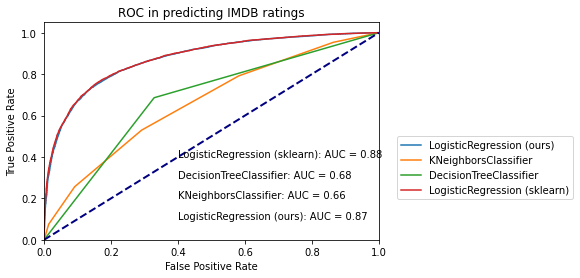

<Figure size 432x288 with 0 Axes>

In [113]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = [KNeighborsClassifier(),
          DecisionTreeClassifier(),
          sk_LogisticRegression()]

perf = {}

# our implementation is slow you may try sklearn version
logitreg = LogisticRegression(max_iters=1e3)
fit = logitreg.fit(imdb_X_train, IMDB_y_train)
y_test_prob = fit.predict(imdb_X_test)
fpr, tpr, thresholds = roc_curve(IMDB_y_test, y_test_prob)
auroc = roc_auc_score(IMDB_y_test, y_test_prob)

perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for model in models:
    fit = model.fit(imdb_X_train, IMDB_y_train)
    y_test_prob = fit.predict_proba(imdb_X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(IMDB_y_test, y_test_prob)
    auroc = roc_auc_score(IMDB_y_test, y_test_prob)
    if type(model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}


plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting IMDB ratings')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
plt.show()
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)
# plt.close()


Horizontal bar plot showing the top 20 features (10 most positive and 10 most negative) from the logistic regression on the IMDB data with the coefficient as the x-axis and the feature names (i.e., words) as the y-axis

[216 245 235  21 299  97 240   5  28 112]


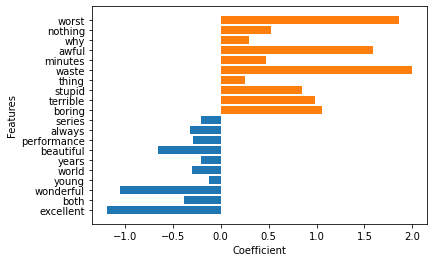

In [118]:
coefficients = model.coef_.transpose().flatten()

#-101 to make indices match 
posindices = pos['indices'].values-101
negindices = neg['indices'].values-101

poscoef = list(coefficients[posindices])
negcoef = list(coefficients[negindices])


plt.barh(poswords,poscoef)
plt.barh(negwords,negcoef)

plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.savefig('feature_LogisReg.png')

